# Imports

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
import statsmodels.api as sm
import warnings
from data_preparation import *
import imblearn
from collections import Counter
from imblearn.under_sampling import NearMiss
import optuna
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
import xgboost as xgb
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import shap

warnings.filterwarnings("ignore")

## Questions à poser

Undersampling : sur le X_train ou bien sur le dataset global
Quelle methode semble la meilleure
Quel ratio choisir
Combien de variables choisir
Augmenter le nombre de modalités par variable peut augmenter l'information?
Quelle méthode de feature selection est à privilégier?


# Dataprep

In [129]:
train_prepared = pd.read_csv('./data/train_prepared.csv')
test_prepared = pd.read_csv('./data/test_prepared.csv')
train_prepared['date_mensuelle'] = pd.to_datetime(train_prepared['date_mensuelle'])
test_prepared['date_mensuelle'] = pd.to_datetime(test_prepared['date_mensuelle'])

train_prepared.drop(columns = 'Unnamed: 0',inplace=True)
test_prepared.drop(columns = 'Unnamed: 0',inplace=True)

train_prepared['CODE_GENDER'] = train_prepared['CODE_GENDER'].apply(lambda x : 'F' if x == 'XNA' else x)
test_prepared['CODE_GENDER'] = test_prepared['CODE_GENDER'].apply(lambda x : 'F' if x == 'XNA' else x)

# One hot encoding

In [130]:
for col in train_prepared.select_dtypes(include='object').columns:
    one_hot_encoded = pd.get_dummies(train_prepared[col], prefix=col, drop_first=True)
    train_prepared = train_prepared.drop(col, axis=1)
    train_prepared = train_prepared.join(one_hot_encoded)

for col in train_prepared.select_dtypes(include=bool).columns:
    train_prepared[col] = train_prepared[col].astype(int)

# UnderSampling 

In [131]:
counter_before = Counter(train_prepared['TARGET'])
counter_before

Counter({0: 282624, 1: 23483})

# Train,Test split

In [223]:
X = train_prepared.copy()
X = X[X['date_mensuelle']<'2020-01-01']
X.drop(columns ='date_mensuelle',inplace=True)
y = train_prepared[train_prepared['date_mensuelle']<'2020-01-01']['TARGET'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)
X_train.drop(columns = ['TARGET'],inplace =True)
X_test.drop(columns = ['TARGET'],inplace =True)

Méthode de sampling choisie : 3 car elle va choisir des exemples de la classe majoritaire qui ont une distance euclidienne minimale avec les echantillons de la classe minoritaire. Avantage : on s'entraine sur des données moins discriminantes pour ne pas donner eu modèle des données 'trop faciles'

In [224]:
undersample = NearMiss(sampling_strategy = 0.3, version = 3 , n_neighbors = 5)
X_train, y_train = undersample.fit_resample(X_train,y_train)

In [225]:
counter_after = Counter(y_train)
counter_after

Counter({0: 35202, 1: 16358})

# Recursive Feature Elimination (RFE)

In [213]:
from sklearn.feature_selection import RFE

logit_model = LogisticRegression()

rfe = RFE(estimator = logit_model, n_features_to_select= 20)

X_train_selected = rfe.fit_transform(X_train,y_train)

selected_variables_names = [x for x, selected in zip(X_train.columns, rfe.support_) if selected]
print(f"Variables selectionnées : {selected_variables_names}")

Variables selectionnées : ['REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2_disc_int_[0.13;0.47]', 'EXT_SOURCE_2_disc_int_[0.47;0.85]', 'EXT_SOURCE_1_disc_int_[0.31;0.96]', 'AMT_GOODS_PRICE_disc_int_[679500.0;4050000.0]', 'EXT_SOURCE_3_disc_int_[0.32;0.9]', 'AMT_CREDIT_disc_int_[675000.0;4050000.0]', 'AMT_ANNUITY_disc_int_[41692.5;258025.5]', 'AMT_REQ_CREDIT_BUREAU_MON_disc_int_[2.0;27.0]', 'OWN_CAR_AGE_disc_int_[1.0;91.0]', 'YEARS_BEGINEXPLUATATION_MEDI_disc_int_[0.97;1.0]', 'YEARS_BEGINEXPLUATATION_MODE_disc_int_[0.97;1.0]', 'YEARS_BEGINEXPLUATATION_AVG_disc_int_[0.97;1.0]', 'NAME_INCOME_TYPE_discret_low_income', 'NAME_INCOME_TYPE_discret_other', 'FLAG_OWN_CAR_Y']


# Logit

In [215]:
#X_train = X_train[selected_variables_names]
#X_test = X_test[selected_variables_names]

In [226]:
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Prédire sur l'ensemble de test
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred)

print("Matrice de confusion :")
print(conf_matrix)

Matrice de confusion :
[[47174  2286]
 [ 3652   437]]


In [227]:
y_prob = model.predict_proba(X_test)[:, 1]

# Calculer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.6493727784652382


# Corretion noms colonnes

In [218]:
new_columns = []
for col in X_train.columns:
    new_col = col.replace('[', '_').replace(']', '_').replace(';', '_').replace('-', '_').replace('.', '_')
    new_columns.append(new_col)

X_train.columns = new_columns


new_columns = []
for col in X_test.columns:
    new_col = col.replace('[', '_').replace(']', '_').replace(';', '_').replace('-', '_').replace('.', '_')
    new_columns.append(new_col)

X_test.columns = new_columns

# Xgboost

In [220]:
def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'max_depth': trial.suggest_int('max_depth',3, 10),
        'eta': trial.suggest_loguniform('eta', 0.05, 0.4),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.3, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 90, 150),
        'alpha': trial.suggest_loguniform('alpha', 0.05, 1.0)
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test,y_pred,output_dict=True)
    f_one = report['1']['f1-score']
    
    y_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    return roc_auc

# Create an Optuna study object and perform the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Display the optimization results
print(f"Best parameters: {study.best_params}")
print(f"Best positive auc score: {study.best_value}")


[I 2024-02-20 16:18:06,254] A new study created in memory with name: no-name-0a59ae80-d114-46f2-afe2-1e40fea611f7
[I 2024-02-20 16:18:09,023] Trial 0 finished with value: 0.641840213755861 and parameters: {'max_depth': 9, 'eta': 0.0609811776303864, 'gamma': 0.002375973170791712, 'colsample_bytree': 0.6716591784329761, 'subsample': 0.9861452917636516, 'n_estimators': 132, 'alpha': 0.35402288557072137}. Best is trial 0 with value: 0.641840213755861.
[I 2024-02-20 16:18:10,099] Trial 1 finished with value: 0.5985965299779067 and parameters: {'max_depth': 9, 'eta': 0.373526438008102, 'gamma': 0.08875710409492764, 'colsample_bytree': 0.5782796552125208, 'subsample': 0.7659223568698703, 'n_estimators': 100, 'alpha': 0.5706704178154857}. Best is trial 0 with value: 0.641840213755861.
[I 2024-02-20 16:18:10,904] Trial 2 finished with value: 0.6582862511109218 and parameters: {'max_depth': 6, 'eta': 0.0634948245117264, 'gamma': 1.989044455552439e-05, 'colsample_bytree': 0.6907077688103787, 'sub

Best parameters: {'max_depth': 4, 'eta': 0.051047917453710075, 'gamma': 0.017636440942899935, 'colsample_bytree': 0.7912845764502913, 'subsample': 0.761980245071002, 'n_estimators': 139, 'alpha': 0.9460887246989023}
Best positive f1 score: 0.6719992574240536


In [221]:
report = classification_report(y_test,y_pred,output_dict=True)
report['1']['f1-score']

0.1434913361019619

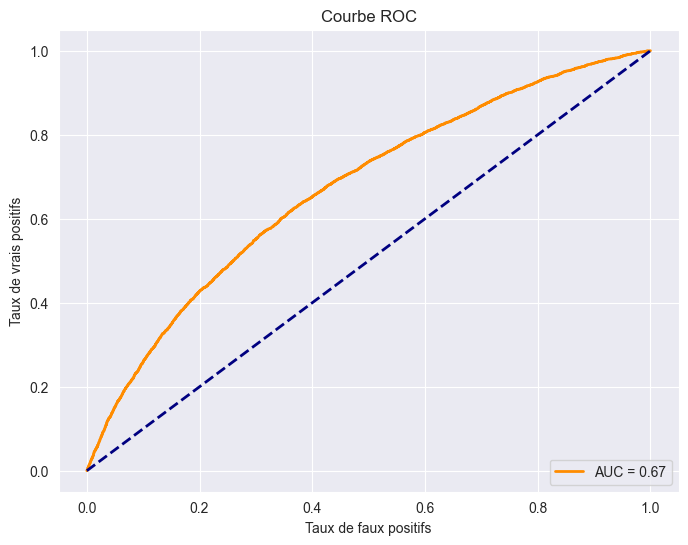

In [222]:
params = study.best_params

model = xgb.XGBClassifier(**params)

model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()

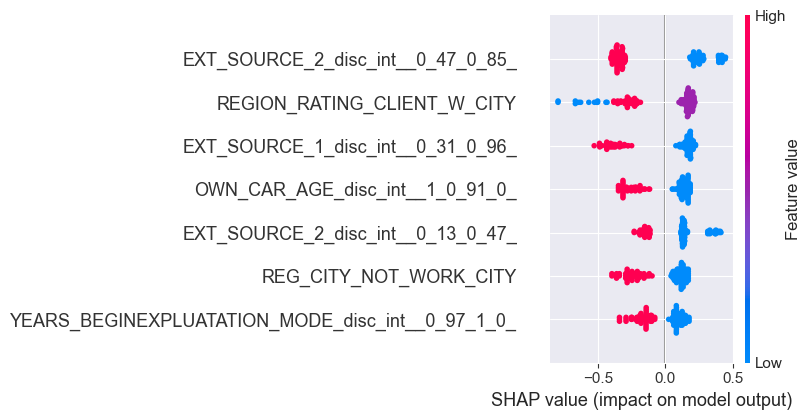

In [165]:
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_train.iloc[:150, :])

shap.summary_plot(shap_values, X_train.iloc[:150, :])

shap_values_single = explainer.shap_values(X_train.iloc[[0]])
shap.force_plot(explainer.expected_value, shap_values_single, X_train.iloc[[0]])

In [150]:
import numpy as np
shap_values_avg = np.abs(shap_values).mean(axis=0)
top_variables_indices = np.argsort(shap_values_avg)[::-1]


n_top_variables = 9
top_variables = X_train.columns[top_variables_indices[:n_top_variables]]

top_variables

Index(['EXT_SOURCE_2_disc_int__0_47_0_85_', 'OWN_CAR_AGE_disc_int__1_0_91_0_',
       'REG_CITY_NOT_WORK_CITY', 'REGION_RATING_CLIENT_W_CITY',
       'EXT_SOURCE_1_disc_int__0_31_0_96_',
       'YEARS_BEGINEXPLUATATION_MODE_disc_int__0_97_1_0_',
       'AMT_GOODS_PRICE_disc_int__679500_0_4050000_0_',
       'EXT_SOURCE_2_disc_int__0_13_0_47_',
       'EXT_SOURCE_3_disc_int__0_32_0_9_'],
      dtype='object')

# ElasticNet

In [114]:
from sklearn.linear_model import LogisticRegressionCV

logit_elasticnet = LogisticRegressionCV(penalty='elasticnet', solver='saga', l1_ratios=[0.5], cv=5, random_state=42)
logit_elasticnet.fit(X_train, y_train)

# Evaluate the model
accuracy = logit_elasticnet.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.6492146596858639


In [115]:
y_pred = logit_elasticnet.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[4893  949]
 [2535 1555]]
